
Here we'll import, analyze and plot the data from our Intentional Skeletons experiment.

First, import.

In [2]:
import pandas as pd
import os

#first get the names of all files
files = [f for f in os.listdir('./data') if f.endswith('.csv')]
alldata = [None]

#import all the files and append them together
for f in files:
    file_path = ("./data/" + str(f))
    data = pd.read_csv(file_path, header=0)
    alldata.append(data)
    
# Concatenate all data into one DataFrame
Intentional_df = pd.concat(alldata, ignore_index=True)
Intentional_df.columns = ["Onset Prime","Jitter","Onset Movie","Onset Response","Resp","RT","actor","item","CTX","Date","framerate","participant","NA"]


#the kinematic information is stored separately. We'll import that here and merge it with the participant dataframe
Kinematics = pd.read_csv('./stimuli/kinematic_data.txt', 
                         sep='\t')
#merge based on a match of both the actor and the item
full_df = Intentional_df.merge(Kinematics, on=['actor','item'], suffixes=('','_'))


Next, I'll check for missing values and convert the kinematic parameters to integers. Basically, get the data ready for analysis.

In [3]:
#remove missing values
data_final = full_df[full_df['RT'].notnull()]

#the kinematic data was imported as df objects, we'll convert the two we're interested in into floats
data_final['SpaceM'] = data_final['SpaceM'].astype(str).astype(float);
data_final['HoldTM'] = data_final['HoldTM'].astype(str).astype(float);

data_final.dtypes #make sure the types are converted


Onset Prime       float64
Jitter            float64
Onset Movie       float64
Onset Response    float64
Resp                int64
RT                float64
actor               int64
item                int64
CTX                 int64
Date               object
framerate          object
participant         int64
NA                float64
Group               int64
filter              int64
Distance           object
DistanceM          object
Space              object
SpaceM            float64
HoldT              object
HoldTM            float64
Subs               object
SubsM              object
Peak               object
PeakM              object
Gaze              float64
Duration          float64
DurationM         float64
dtype: object

Now we can run our analyses.
We want to test if the videos are being classified based on their kinematics. If so, we should expect their to be a difference in the kinematics when comparing the classifications. So we'll run an ANOVA, then get the means of each classification category.

In [4]:
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
#from statsmodels.formula.api import ols


data_final['Resp'].replace({1: 'Teacher', 2: 'Neutral', 3: 'Student'}, inplace= True)


#get summary stats
print('\t\tRT')
print(rp.summary_cont(data_final['RT'].groupby(data_final['Resp']))) #RT per choice
print('\n\t\tSpace')
print(rp.summary_cont(data_final['SpaceM'].groupby(data_final['Resp']))) #Space per choice
print('\n\t\tHoldtime')
print(rp.summary_cont(data_final['HoldTM'].groupby(data_final['Resp']))) #Holdtime per choice


#run the ANOVA
#first for Space
print('\n\nSpace:\t')
print(stats.f_oneway(data_final['SpaceM'][data_final['Resp'] == 'Teacher'], 
             data_final['SpaceM'][data_final['Resp'] == 'Neutral'],
             data_final['SpaceM'][data_final['Resp'] == 'Student'])
     )


#then for Holdtime
print('\n\nHoldtime:\t')
print(stats.f_oneway(data_final['HoldTM'][data_final['Resp'] == 'Teacher'], 
             data_final['HoldTM'][data_final['Resp'] == 'Neutral'],
             data_final['HoldTM'][data_final['Resp'] == 'Student'])
     )
#planned comparisons - which categories correspond to higher kinematic values?
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#we'll only do this for Space, since Holdtime is not significant
mc_Space = MultiComparison(data_final['SpaceM'], data_final['Resp'])
mc_results_Space = mc_Space.tukeyhsd()
print('\n\nPlanned comparisons: Space\n')
print( mc_results_Space)



		RT


          N      Mean        SD        SE  95% Conf.  Interval
Resp                                                          
Neutral  34  0.762863  0.609156  0.104469   0.555023  0.970702
Student  36  0.679917  0.573351  0.095558   0.489965  0.869868
Teacher  49  0.510514  0.380227  0.054318   0.402947  0.618081

		Space


          N      Mean        SD        SE  95% Conf.  Interval
Resp                                                          
Neutral  34 -0.209529  0.804080  0.137899  -0.483875  0.064817
Student  36 -0.475558  0.719463  0.119910  -0.713916 -0.237199
Teacher  49  0.097731  1.179066  0.168438  -0.235829  0.431291

		Holdtime


          N      Mean        SD        SE  95% Conf.  Interval
Resp                                                          
Neutral  34 -0.109640  0.956729  0.164078  -0.436068  0.216789
Student  36 -0.164419  0.870700  0.145117  -0.452883  0.124044
Teacher  49  0.021609  0.952033  0.136005  -0.247722  0.290941


Space:	
F_onewayResul

Finally, we'll plot the distributions.

C:\Users\James\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


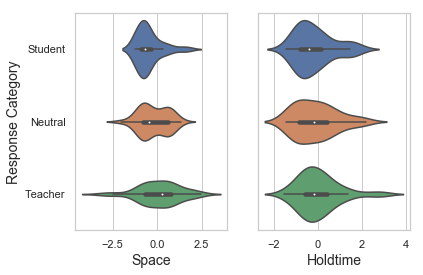

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

#give us the background lines
sns.set(style="whitegrid")


fig, (ax1, ax2)= plt.subplots(1, 2)

sns.violinplot(x='SpaceM', y='Resp', data=data_final,
               sharey='row',
              ax = ax1)

sns.violinplot(x='HoldTM', y='Resp', data=data_final,
               sharey='row',
              ax = ax2)
ax2.axes.get_yaxis().set_visible(False)#make the y-axis invisible, so it's shared
#now adjust font sizes
ax1.xaxis.label.set_fontsize(14)
ax2.xaxis.label.set_fontsize(14)
#and make the labels more informative
ax1.set_ylabel('Response Category',fontsize=14);
ax1.set_xlabel('Space');
ax2.set_xlabel('Holdtime');
